# Setup

### Path setup

In [1]:
import os

In [2]:
path_to_this_folder = os.getcwd() # Do it before calling %cd ../.. so that the path is accurate

### Project setup

In [3]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"   # Prevent internal ngsolve imports from killing the kernel


In [4]:
%cd ../..
!pip install .
!pip install meshio
!pip install ngsolve




c:\Users\octav\Documents\GitHub\Stage_ARIA
Processing c:\users\octav\documents\github\stage_aria
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for yourpkg: filename=yourpkg-0.1.0-py3-none-any.whl size=37708 sha256=d806bab0ff37c60527833e7ab1de4315c4571de5778a54f492b6e0485808e5b3
  Stored in directory: C:\Users\octav\AppData\Local\Temp\pip-ephem-wheel-cache-mr4kru65\wheels\2f\97\6f\4cd56f403f3905a3673325538741a3519ba70ae59cdd7d492e
Successfully built yourpkg
  Attempting uninstall: yourpkg
    Found existing installation: yourpkg 0.1.0
    Uninstalling yourpkg-0.1.0:
      Successfully uninstalled yourpkg-0.1.0


### Imports

Usual libraries

In [5]:
import tomllib
from time import time
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm
import numpy as np


Custom code

In [6]:
from src.Pre_processing.process_hardware import get_precision, get_device
from src.Pre_processing.process_gmsh import read_gmsh, get_nodes_and_elements_IDs
from src.FENN.VertexNN.FEENN_2D.FEENN import FEENN_2D
from src.FENN.VertexNN.FEENN_2D.Element import Tri_2D_lin
from src.FENN.VertexNN.FEENN_2D.Mapping import Mapping_2D_Affine
from src.FENN.ConstantNN.constantNN import ConstantNN
from src.FENN.L2NN.field_L2NN import Field_L2NN
from src.PropertiesNN.PropertiesNN import PropertiesNN
from src.Pre_processing.build_solver import build_solver
from src.PDE.Magnetostatic_Optim_2D_loss import Magnetostatic_Optim_2D_loss
from src.PDE.operators import curl
from src.MaterialNN.BinarySelection import BinarySelection
from src.Baselines.Poisson_2D.Uniform.baseline import baseline
from src.Post_processing.VTKExport.export_vtk import export_vtk



### Number precision

In [7]:
IntPrecision = torch.int32
FloatPrecision = torch.float64

### Hardware

Note that for cases of small meshes cpu outperforms gpu

In [8]:
device = 'cpu'

# Problem description and problem-related variables definition

$$
\begin{align*}
        \;&\text{Find }&&\overrightarrow{A}^*,\rho^* =\arg\min_{\overrightarrow{A}\in H\left(\overrightarrow{\text{rot}},\Omega\right), \rho\in L^2(\Omega)}\int_\Omega \frac{1}{2\mu(x)}\cdot\overrightarrow{\text{curl}}\left(\overrightarrow{A}\right) \cdot\overrightarrow{\text{curl}}\left(\overrightarrow{A}\right)-\overrightarrow{j}\cdot\overrightarrow{A}\text{d}\Omega
        + \lambda\frac{\int_\Omega \rho(x)\text{d}\Omega}{\int_\Omega\text{d}\Omega}
        \\\\
        &\text{s.t}&&\overrightarrow{A}(x^+)\cdot \overrightarrow{e}_z=A_0\\
        &&&\overrightarrow{A}(x^-)\cdot \overrightarrow{e}_z = -A_0\\
        &&&\overrightarrow{A}(x) = \overrightarrow{0}&\forall x\in\partial \Omega\\
        &&&\mu(x) = \mu_0&\forall x\in \Omega \backslash \Omega^+\bigcup\Omega^-\\
        &&&\mu_0\leq\mu(x)\leq\mu_1&\forall x\in\Omega^+\bigcup\Omega^-\\
        &&&\overrightarrow{j}(x) = \overrightarrow{0}&\forall x\in \Omega\\
        
    \end{align*}
$$



$\mu$ can multiple values between $\mu_0$ and $\mu_1$ depending on the location in $\Omega$.  
For conveniency 
- we use $\nu = \frac{1}{\mu}$
- we enforce the switch between $\nu_0$ and $\nu_1$ through a soft choice field $\rho:\Omega\to[0,1]$ such that
$$
\nu(x) = (1-\rho(x))\nu_0 +\rho(x)\nu_1
$$

We enforce $\rho:\Omega\to[0,1]$ through the auxiliary field $\hat{\rho}:\Omega\to\mathbb{R}$ and the sigmoïd.
$$
\begin{align*}
    \;&\rho(x)=\mathbb{I}\left\{x\notin \Omega^+\bigcup\Omega^-\right\}\sigma\left(\hat{\rho}(x)-\frac{1}{2}\right)
\end{align*}
$$

After the optimization, one can force $\mu(x)\in\{\mu_0,\mu_1\}$ by taking
$$
\nu(x) = (1-p(x))\nu_0 +p(x)\nu_1
$$

Where $p$ is the hard choice field given by :
$$
p(x) = \mathbb{I}\left\{\rho(x)\geq 0.5\right\}
$$

$\Omega$ is defined through a .msh file

In [ ]:
# path_to_msh = os.path.join(path_to_this_folder, "Coil.msh")
# path_to_msh = os.path.join(path_to_this_folder, "Coil_fine.msh")
# path_to_msh = os.path.join(path_to_this_folder, "Coil_interm.msh")
path_to_msh = os.path.join(path_to_this_folder, "Coil_TC.msh")

Define $\nu_0$ and $\nu_1$

In [10]:
nu_0_value = 1
nu_1_value = 2e-4

No source term because $\overrightarrow{j} = \overrightarrow{0}$ in $\Omega$.

The problem is set in 2D

In [11]:
interior_dim = 2
boundary_dim = 1

$\overrightarrow{A}$ is a vector field that can be represented as a scalar field carried by $\overrightarrow{e}_z$. Hence only one component is necessary to identify $\overrightarrow{A}$.

In [12]:
n_components = 1

dirichlet_exterior = {'entity_name'         : 'Exterior',
                        'Value'              : 0}

dirichlet_positive_source = {'entity_name'                       : 'Positive_source',
                            'entity_dim'                         : 0,
                            'Value'                              : 1 }

dirichlet_negative_source = {'entity_name'                       : 'Negative_source',
                            'entity_dim'                         : 0,
                            'Value'                              : -1}

dirichlet_config = [dirichlet_exterior, dirichlet_positive_source, dirichlet_negative_source]

We use a linear interpolation for our FEM representation of $V$. Therefore $\overrightarrow{\text{curl}}(\overrightarrow{A})$ is constant by element and the appropriate integration scheme is an order 1 gaussian quadrature.

In [13]:
quadrature_order = 1

# FENN solve

Read the gmsh file and get the mesh related info

In [14]:
gmsh_mesh = read_gmsh(path_to_msh = path_to_msh,
                      IntPrecision = IntPrecision,
                      FloatPrecision = FloatPrecision)

Nodes = gmsh_mesh.nodes
connectivity = gmsh_mesh.elements[str(interior_dim)]['connectivity']

Processing GMSH file:   0%|          | 0/23409 [00:00<?, ?it/s]

Processing GMSH file: 100%|██████████| 23409/23409 [00:00<00:00, 201264.48it/s]


## One specific FENN solve

Note : We wrap everything into modulable functions so that its easier to do the pareto front in the next part

Build a field candidate

In [15]:
def build_field_candidate():
    global gmsh_mesh, Nodes, connectivity, dirichlet_config, interior_dim, boundary_dim, IntPrecision, FloatPrecision, n_components, quadrature_order, device

    

    # Build the field candidate. Here we use a linear interpolation scheme.
    A = FEENN_2D(Nodes = Nodes,
                connectivity=connectivity,
                n_components=n_components,
                element=Tri_2D_lin(IntPrecision=IntPrecision, FloatPrecision=FloatPrecision),
                mapping = Mapping_2D_Affine(),
                IntPrecision=IntPrecision,
                FloatPrecision=FloatPrecision)

    # Apply dirichlet
    for dirichlet in dirichlet_config:

        nodeIDs, _ = get_nodes_and_elements_IDs(gmsh_mesh=gmsh_mesh,
                                                entity_dim = dirichlet.get('entity_dim', boundary_dim),
                                                entity_name = dirichlet.get('entity_name', None),
                                                entity_tag = dirichlet.get('entity_tag', None))
        
        
        value = dirichlet['Value']*torch.ones_like(nodeIDs, dtype = FloatPrecision).unsqueeze(-1)

        A.SetBCs(Fixed_nodal_coordinates_Ids = nodeIDs,
                Fixed_nodal_values_Ids = nodeIDs,
                Fixed_nodal_values_values = value)
        

    # Specify the integration scheme
    A.SetQuad(quadrature_order = quadrature_order)
    A.Freeze(freeze_grid=True, freeze_interpolation=False)

    # Move the object to the chosen hardware
    A.to(device)

    # Specify that A should store its evolution so that we can export it to vtk
    A.StoreResults()

    return A

Define the material

In [ ]:
def build_material():
    global gmsh_mesh, u_0_value, nu_1_value, IntPrecision, FloatPrecision, interior_dim, device
    
    connectivity = gmsh_mesh.elements[str(interior_dim)]['connectivity']

    # Define the nu_0 property
    nu_0 = ConstantNN(property_value=nu_0_value,
                        IntPrecision = IntPrecision,
                        FloatPrecision = FloatPrecision)

    # nu_0 is not a field to be found
    nu_0.setBCs(is_fixed=True)

    # Define the nu_1 property
    nu_1 = ConstantNN(property_value=nu_1_value,
                        IntPrecision = IntPrecision,
                        FloatPrecision = FloatPrecision)

    # nu_1 is not a field to be found
    nu_1.setBCs(is_fixed=True)


    # Define the nu property using nu_0 and nu_1
    # BinarySelection.forward(el_ids, NPoints, *args, **kwargs) -> (1-choice)*self.properties['property_1'](el_ids, NPoints, *args, **kwargs) + choice*self.properties['property_2'](el_ids, NPoints, *args, **kwargs)
    nu = BinarySelection(property_1     = nu_0,
                        property_2     = nu_1,
                        NElem          = len(connectivity),
                        IntPrecision   = IntPrecision,
                        FloatPrecision = FloatPrecision)


    # Note that we do not enforce anything in "domain_no_coil", i.e : nu is a field to be found in that part of the domain
   

    # Set the value of nu to nu_0 in "coil_1"
    _, elemIDs = get_nodes_and_elements_IDs(gmsh_mesh=gmsh_mesh,
                                                entity_dim=interior_dim,
                                                entity_name = 'coil_1')

    nu.setBCs(Fixed_Ids=elemIDs, specific_value=torch.zeros_like(elemIDs))

    # Set the value of nu to nu_0 in "coil_2"
    _, elemIDs = get_nodes_and_elements_IDs(gmsh_mesh=gmsh_mesh,
                                                entity_dim=interior_dim,
                                                entity_name = 'coil_2')

    nu.setBCs(Fixed_Ids=elemIDs, specific_value=torch.zeros_like(elemIDs))

    # The only problem-relevant material property is nu
    Mat = PropertiesNN(dim = interior_dim,
                    NElem = len(connectivity),
                    IntPrecision = IntPrecision,
                    FloatPrecision = FloatPrecision)

    Mat.add_property(property_name = 'nu',
                    property = nu)

    # Move the object to the chosen hardware
    Mat.to(device)

    return Mat

Define the objective function and how the fields of interest should be saved

In [17]:
def build_objective_function(run_index, lagrange_multiplier):
    specific_run_name = f'optim_run_{run_index}_lagrange_multiplier_{lagrange_multiplier}'

    path_to_main_vtk_folder = os.path.join(os.path.join(path_to_this_folder, 'Results'), 'VTK_exports')
    os.makedirs(path_to_main_vtk_folder, exist_ok = True)

    path_to_specific_vtk_folder = os.path.join(path_to_main_vtk_folder, specific_run_name)

    vtk_export_config = {'path_to_folder'       : path_to_specific_vtk_folder,
                    'cell_data'             : ['B', 'potential', 'j', 'field_term', 'source_term', 'nu', 'mapping_det', 'soft_choice', 'hard_choice'],
                    'point_data'            : ['A'],
                    'export_vtk'            : True}
    

    loss = Magnetostatic_Optim_2D_loss(IntPrecision=IntPrecision, 
                                        FloatPrecision=FloatPrecision,
                                        vtk_export = vtk_export_config,
                                        lagrange_multiplier = lagrange_multiplier)

    return loss

Specify the solver and build it. Beware that even though the physics is convex, the overall objective is not. Nevertheless, LBFGS (quasi-Newton) behaves well in practice.

In [18]:
def specify_solver(loss, A, Mat, lagrange_multiplier):
    solver_config = {'optimizer'               :  'lbfgs',
            'n_epochs'                :  5000,
            'loss_decrease_c'         :   1e-13,
            'freeze_grid'             :   True,
            'freeze_interpolation'    :   False,
            'freeze_Mat'              :   False,
            'budget'                  : 0,
            'lagrange_multiplier'     : 0,
            'focus_multiplier'        : lagrange_multiplier}

    solver = build_solver(solver_config = solver_config,
                        loss = loss,
                        model = A,
                        Mat = Mat)
    
    return solver

Extract, plot, save and return some metrics

In [19]:
def extract_plot_save_and_return_some_metrics(run_index, lagrange_multiplier, solver):

    # Get all metrics of interest
    epochs, loss = solver.get_metric()
    time_steps, _ = solver.get_metric(use_time = True)
    _, physical_loss = solver.get_metric(name = 'potential')
    _, constraint_loss = solver.get_metric(name = 'volume_term')

    
    # Define the path to the main plot save folder
    save_folder = os.path.join(os.path.join(path_to_this_folder, 'Results'), 'Plots')
    os.makedirs(save_folder, exist_ok=True)

    # Define the path to the run-related plots
    specific_save_folder = os.path.join(save_folder, f"run_{run_index}_lagrange_multiplier_{lagrange_multiplier}")
    os.makedirs(specific_save_folder, exist_ok=True)

    # Plot and save the loss evolution
    save_name = f"loss.png"
    save_path = os.path.join(specific_save_folder, save_name)
    plt.clf()
    plt.plot(epochs, loss)
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'run {run_index}\t,\t'+r'$\lambda$ = '+f'{lagrange_multiplier}')
    plt.grid(True, which='both')
    plt.savefig(save_path)
    
    # Plot and save the physics-related term evolution
    save_name = f"physics_loss.png"
    save_path = os.path.join(specific_save_folder, save_name)
    plt.clf()
    plt.plot(epochs, physical_loss)
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Magnetic energy')
    plt.title(f'run {run_index}\t,\t'+r'$\lambda$ = '+f'{lagrange_multiplier}')
    plt.grid(True, which='both')
    plt.savefig(save_path)

    # Plot and save the volume-related term evolution
    save_name = f"constraint_loss.png"
    save_path = os.path.join(specific_save_folder, save_name)
    plt.clf()
    plt.plot(epochs, constraint_loss)
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Volume constraint')
    plt.title(f'run {run_index}\t,\t'+r'$\lambda$ = '+f'{lagrange_multiplier}')
    plt.grid(True, which='both')
    plt.savefig(save_path)

    # Return the last metrics values from multiple-run related plots
    return time_steps[-1], physical_loss[-1], constraint_loss[-1]


Wrap everything

In [20]:
def optim_run(run_index, lagrange_multiplier):

    # Build every object of interest
    A = build_field_candidate()
    Mat = build_material()
    loss = build_objective_function(run_index, lagrange_multiplier)
    solver = specify_solver(loss, A, Mat, lagrange_multiplier)

    # Solve
    solver.solve()

    # Metric processing
    duration, physical_loss, constraint_loss = extract_plot_save_and_return_some_metrics(run_index, lagrange_multiplier, solver)

    # Return some run-based metrics for the overall pareto front
    return duration, physical_loss, constraint_loss

    

## FENN solve for multiple lagrange multipliers

Set the considered multiplier values

In [21]:
# # What was done for the paper
# lagrange_multipliers_start = -6
# lagrange_multipliers_stop = 3
# lagrange_multipliers_number = 100
# lagrange_multipliers = torch.logspace(start = lagrange_multipliers_start, end = lagrange_multipliers_stop, steps = lagrange_multipliers_number).data.numpy()

# Improved choice

low_lagrange_multipliers = torch.logspace(start = -5, end = -1, steps = 5).data.numpy()

middle_lagrange_multipliers = torch.logspace(start = -1, end = 2, steps = 15).data.numpy()

high_lagrange_multipliers = torch.logspace(start = 2, end = 3, steps = 5).data.numpy()

lagrange_multipliers = np.concatenate([low_lagrange_multipliers, middle_lagrange_multipliers, high_lagrange_multipliers])


Do all runs

c:\Users\octav\Documents\GitHub\Stage_ARIA\src\FENN\VertexNN\FEENN_2D\FEENN.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('connectivity', torch.tensor(connectivity, dtype = self.ref_int.dtype))




###############################################################################
Run	:	0/25
lagrange_multiplier	:	9.999999747378752e-06




Solving (worse case scenario):  51%|█████     | 2553/5000 [37:13<12:04,  3.38it/s, time=2.23e+3]  c:\Users\octav\Documents\GitHub\Stage_ARIA\src\FENN\VertexNN\FEENN_2D\FEENN.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('connectivity', torch.tensor(connectivity, dtype = self.ref_int.dtype))




###############################################################################
Run	:	1/25
lagrange_multiplier	:	9.999999747378752e-05




Solving (worse case scenario):  53%|█████▎    | 2647/5000 [35:34<31:37,  1.24it/s, time=2.13e+3]




###############################################################################
Run	:	2/25
lagrange_multiplier	:	0.0010000000474974513




Solving (worse case scenario):  51%|█████     | 2554/5000 [31:07<16:49,  2.42it/s, time=1.87e+3]



###############################################################################
Run	:	3/25
lagrange_multiplier	:	0.009999999776482582




Solving (worse case scenario):  51%|█████     | 2554/5000 [51:26<49:15,  1.21s/it, time=1.87e+3]




###############################################################################
Run	:	4/25
lagrange_multiplier	:	0.10000000149011612




Solving (worse case scenario):  46%|████▌     | 2307/5000 [1:13:15<1:25:30,  1.91s/it, time=1.7e+3]



###############################################################################
Run	:	5/25
lagrange_multiplier	:	0.10000000149011612





Solving (worse case scenario):  73%|███████▎  | 3673/5000 [45:08<16:18,  1.36it/s, time=2.71e+3]




###############################################################################
Run	:	6/25
lagrange_multiplier	:	0.16378937661647797




Solving (worse case scenario):  59%|█████▉    | 2968/5000 [36:32<25:00,  1.35it/s, time=2.19e+3]  




###############################################################################
Run	:	7/25
lagrange_multiplier	:	0.2682695686817169




Solving (worse case scenario):  53%|█████▎    | 2631/5000 [32:10<28:58,  1.36it/s, time=1.93e+3]




###############################################################################
Run	:	8/25
lagrange_multiplier	:	0.43939706683158875




Solving (worse case scenario):  52%|█████▏    | 2602/5000 [32:31<29:58,  1.33it/s, time=1.95e+3] 




###############################################################################
Run	:	9/25
lagrange_multiplier	:	0.7196856737136841




Solving (worse case scenario):  38%|███▊      | 1911/5000 [23:26<37:53,  1.36it/s, time=1.41e+3]




###############################################################################
Run	:	10/25
lagrange_multiplier	:	1.1787686347961426




Solving (worse case scenario):  38%|███▊      | 1889/5000 [23:09<38:07,  1.36it/s, time=1.39e+3]




###############################################################################
Run	:	11/25
lagrange_multiplier	:	1.9306976795196533




Solving (worse case scenario):  25%|██▌       | 1267/5000 [15:32<45:47,  1.36it/s, time=932]  




###############################################################################
Run	:	12/25
lagrange_multiplier	:	3.1622776985168457




Solving (worse case scenario):  30%|██▉       | 1481/5000 [18:05<42:58,  1.36it/s, time=1.08e+3]  




###############################################################################
Run	:	13/25
lagrange_multiplier	:	5.179474830627441




Solving (worse case scenario):  20%|██        | 1014/5000 [12:18<48:23,  1.37it/s, time=738]  




###############################################################################
Run	:	14/25
lagrange_multiplier	:	8.483428955078125




Solving (worse case scenario):  21%|██        | 1046/5000 [12:38<47:47,  1.38it/s, time=758]  




###############################################################################
Run	:	15/25
lagrange_multiplier	:	13.894954681396484




Solving (worse case scenario):  11%|█         | 528/5000 [06:23<54:05,  1.38it/s, time=383]   




###############################################################################
Run	:	16/25
lagrange_multiplier	:	22.758459091186523




Solving (worse case scenario):  19%|█▊        | 929/5000 [11:17<49:26,  1.37it/s, time=676]   




###############################################################################
Run	:	17/25
lagrange_multiplier	:	37.275936126708984




Solving (worse case scenario):   7%|▋         | 347/5000 [04:16<57:22,  1.35it/s, time=256]   




###############################################################################
Run	:	18/25
lagrange_multiplier	:	61.05402374267578




Solving (worse case scenario):   6%|▌         | 275/5000 [03:19<57:12,  1.38it/s, time=199]   




###############################################################################
Run	:	19/25
lagrange_multiplier	:	100.0




Solving (worse case scenario):   2%|▏         | 106/5000 [01:13<56:20,  1.45it/s, time=72.7] 




###############################################################################
Run	:	20/25
lagrange_multiplier	:	100.0




Solving (worse case scenario):   2%|▏         | 106/5000 [01:13<56:13,  1.45it/s, time=72.5] 




###############################################################################
Run	:	21/25
lagrange_multiplier	:	177.82794189453125




Solving (worse case scenario):   1%|▏         | 67/5000 [00:47<58:18,  1.41it/s, time=46.9]  




###############################################################################
Run	:	22/25
lagrange_multiplier	:	316.2277526855469




Solving (worse case scenario):   1%|          | 39/5000 [00:24<51:31,  1.60it/s, time=23.8]  




###############################################################################
Run	:	23/25
lagrange_multiplier	:	562.34130859375




Solving (worse case scenario):   1%|          | 32/5000 [00:21<55:11,  1.50it/s, time=20.8]  




###############################################################################
Run	:	24/25
lagrange_multiplier	:	1000.0




Solving (worse case scenario):   1%|          | 31/5000 [00:19<24:39,  3.36it/s, time=19.1]  

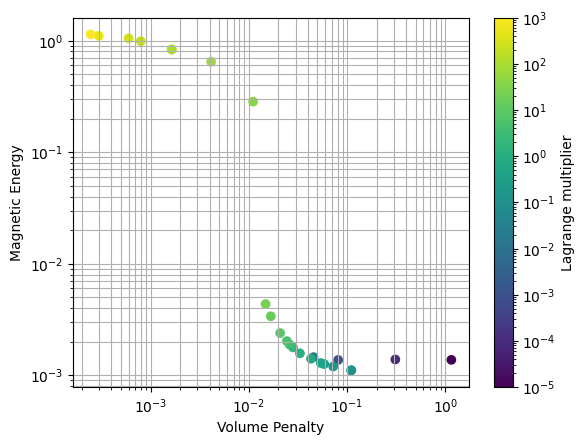

In [22]:
all_durations = []
all_physical_loss = []
all_constraint_loss = []

# Solve the optimization problem for every multiplier values and stores the metrics values at convergence
for run_index, lagrange_multiplier in enumerate(lagrange_multipliers):
    print(f'\n\n###############################################################################\nRun\t:\t{run_index+1}/{len(lagrange_multipliers)}\nlagrange_multiplier\t:\t{lagrange_multiplier}\n\n')


    

    duration, physical_loss, constraint_loss = optim_run(run_index, lagrange_multiplier)

    all_durations.append(duration)
    all_physical_loss.append(physical_loss)
    all_constraint_loss.append(constraint_loss)

# Define the path to the main plot save folder
save_folder = os.path.join(os.path.join(path_to_this_folder, 'Results'), 'Plots')
os.makedirs(save_folder, exist_ok=True)

# Define the path to the global plots save folder
specific_save_folder = os.path.join(save_folder, f"Global_plots")
os.makedirs(specific_save_folder, exist_ok=True)

# Plot and save the physics-related term at convergence vs the lagrange multiplier values
save_name = f'Physics_vs_lagrange_multipliers.png'
save_path = os.path.join(specific_save_folder, save_name)

plt.clf()
plt.plot(lagrange_multipliers, all_physical_loss, '.')
plt.xlabel('Weight')
plt.ylabel('Magnetic energy')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both')
plt.savefig(save_path)

# Plot and save the volume-related term at convergence vs the lagrange multiplier values
save_name = f'Volume_vs_lagrange_multipliers.png'
save_path = os.path.join(specific_save_folder, save_name)

plt.clf()
plt.plot(lagrange_multipliers, all_constraint_loss, '.')
plt.xlabel('Weight')
plt.ylabel('Volume penalty')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both')
plt.savefig(save_path)

# Plot and save the physics-related term at convergence vs the volume-related term at convergence (i.e : pareto front of the optimization problem)
save_name = f'Pareto.png'
save_path = os.path.join(specific_save_folder, save_name)

plt.clf()
plt.scatter(all_constraint_loss, all_physical_loss, c=lagrange_multipliers, cmap='viridis', norm=LogNorm())
plt.colorbar(label="Lagrange multiplier")  # Optional color legend to add infos on the lagrange multiplier dependencies
plt.xlabel("Volume Penalty")
plt.ylabel("Magnetic Energy")
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both')
plt.savefig(save_path)

# Define the path to the metrics save folder (to allow for some additionnal post-processing)
save_folder = os.path.join(os.path.join(path_to_this_folder, 'Results'), 'Run_wise_metrics')
os.makedirs(save_folder, exist_ok=True)

# Save every global metrics
all_durations       =   np.array(all_durations)
all_physical_loss   =   np.array(all_physical_loss)
all_constraint_loss =   np.array(all_constraint_loss)

np.save(os.path.join(save_folder, f'all_durations.npy'), all_durations)
np.save(os.path.join(save_folder, f'all_physical_loss.npy'), all_physical_loss)
np.save(os.path.join(save_folder, f'all_constraint_loss.npy'), all_constraint_loss)
np.save(os.path.join(save_folder, f'lagrange_multipliers.npy'), lagrange_multipliers)

    